<a href="https://colab.research.google.com/github/ada-my619/Seismic_Facies_Interpretation/blob/main/Seismic_Facies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 44.3 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [3]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [4]:
set_seed(42)

True

In [5]:
# download the files:
#!wget https://zenodo.org/record/3755060/files/data.zip
# check that the md5 checksum matches:
#!openssl dgst -md5 data.zip # Make sure the result looks like this: MD5(data.zip)= bc5932279831a95c0b244fd765376d85, otherwise the downloaded data.zip is corrupted.
# unzip the data:
#!unzip data.zip
# create a directory where the train/val/test splits will be stored:
#!mkdir data/splits

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# !cp ./data.zip /content/drive/MyDrive/data.zip

In [8]:
!ls -lh /content/drive/MyDrive/

total 1003M
drwx------ 2 root root  4.0K Nov 26 11:23 'Colab Notebooks'
-rw------- 1 root root 1003M Dec 30 21:53  data.zip
-rw------- 1 root root    67 Nov 25 17:01  kaggle.json
drwx------ 2 root root  4.0K Nov 26 14:28  models
drwx------ 2 root root  4.0K Dec 30 21:34  seismic_project


In [9]:
!cp /content/drive/MyDrive/data.zip .

In [10]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/test_once/test1_seismic.npy  
  inflating: data/test_once/test2_labels.npy  
  inflating: data/test_once/test1_labels.npy  
  inflating: data/test_once/test2_seismic.npy  
  inflating: data/.dropbox           


In [11]:
from matplotlib import pyplot as plt
import numpy as np

train_seismic = np.load('data/train/train_seismic.npy')
train_labels = np.load('data/train/train_labels.npy')
train_seismic.shape, train_labels.shape

((401, 701, 255), (401, 701, 255))

In [51]:
class SeismicSliceDataset(Dataset):
    def __init__(self, seismic_path, labels_path, axis=0, transform=None):
        self.seis = np.load(seismic_path)   # memory-friendly
        self.lab  = np.load(labels_path)
        assert self.seis.shape == self.lab.shape
        self.axis = axis
        self.transform = transform

        self.n = self.seis.shape[axis]  # number of slices

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # take a slice along chosen axis
        x = np.take(self.seis, idx, axis=self.axis)  # (401,701) if axis=2
        y = np.take(self.lab,  idx, axis=self.axis)

        # convert types
        x = torch.from_numpy(np.array(x)).float().unsqueeze(0)  # (1,H,W)
        y = torch.from_numpy(np.array(y)).long()               # (H,W) for CE loss

        if self.transform:
            x, y = self.transform(x, y)

        return x, y

In [52]:
train_dataset = SeismicSliceDataset(seismic_path='data/train/train_seismic.npy', labels_path='data/train/train_labels.npy')
train_dataset

In [53]:
len(train_dataset)

401

In [54]:
train_dataset[0][0].shape

torch.Size([1, 701, 255])

torch.Size([701, 255])


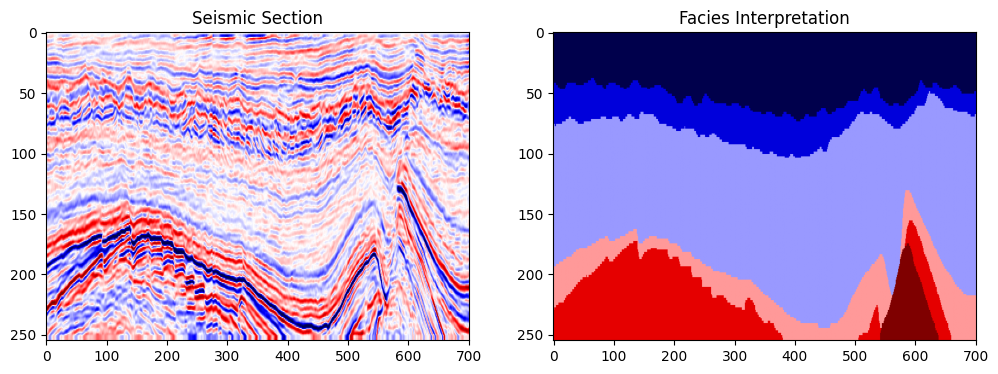

In [55]:
x, y = train_dataset[0]
print(y.shape)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [56]:
from torch.utils.data import Subset

n_total = len(train_dataset)
split_idx = int(0.8 * n_total)

train_indices = list(range(0, split_idx))
val_indices   = list(range(split_idx, n_total))

train_ds = Subset(train_dataset, train_indices)
val_ds   = Subset(train_dataset, val_indices)

torch.Size([701, 255])


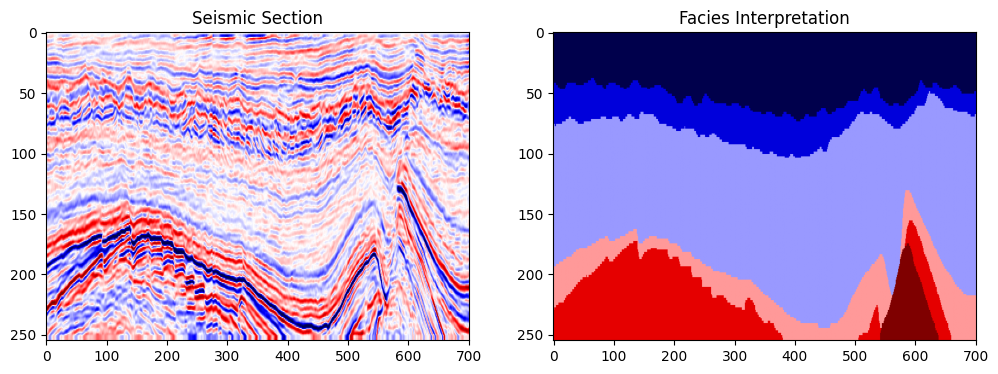

In [57]:
x, y = train_ds[0]
print(y.shape)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [58]:
batch_size = 8

In [59]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [60]:
import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.c = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(output_channel)
    self.activation = nn.SiLU()

  def forward(self, x):
    x = self.c(x)
    x = self.bn(x)
    x = self.activation(x)
    return x

class DecBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.up = nn.ConvTranspose2d(input_channel, output_channel, kernel_size=2, stride=2, padding=0)
    self.conv_block1 = ConvBlock(output_channel * 2, output_channel) # 2 times for handling skip connection, double the channel size since we concat on the channel dim
    self.conv_block2 = ConvBlock(output_channel, output_channel)

  def forward(self, x, s):
    h = self.up(x)
    h = torch.cat([h, s], axis=1)
    h = self.conv_block1(h)
    h = self.conv_block2(h)
    return h

class EncBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.conv_block1 = ConvBlock(input_channel, output_channel)
    self.conv_block2 = ConvBlock(output_channel, output_channel)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    h = self.conv_block1(x)
    h = self.conv_block2(h)
    p = self.pool(h)
    return h, p


In [61]:
class UNet(nn.Module):
    def __init__(self, in_channels = 1, n_classes = 6):
      super().__init__()
      self.e1 = EncBlock(in_channels, 8)
      self.e2 = EncBlock(8, 16)
      self.e3 = EncBlock(16, 32)
      self.e4 = EncBlock(32, 64)
      self.b1 = ConvBlock(64, 128)
      self.d1 = DecBlock(128, 64)
      self.d2 = DecBlock(64, 32)
      self.d3 = DecBlock(32, 16)
      self.d4 = DecBlock(16, 8)
      self.output = nn.Conv2d(8, n_classes, kernel_size=1, padding=0) # we keep the size, just reduce the channels

    def forward(self, x):
      B, C, H, W = x.shape
      # print(B, C, H, W)
      # --- auto pad to multiples of 16 ---
      pad_h = (16 - H % 16) % 16
      pad_w = (16 - W % 16) % 16

      x = F.pad(x, (0, pad_w, 0, pad_h))  # (left,right,top,bottom)

      s1, x = self.e1(x)
      s2, x = self.e2(x)
      s3, x = self.e3(x)
      s4, x = self.e4(x)
      x = self.b1(x)
      x = self.d1(x, s4)
      x = self.d2(x, s3)
      x = self.d3(x, s2)
      x = self.d4(x, s1)
      output = self.output(x)
      output = output[:, :, :H, :W]
      # print(output.shape)
      return output

In [202]:
unet = UNet(in_channels=1, n_classes=6).to(device)
unet

UNet(
  (e1): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [203]:
summary(unet, (1, 701, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 704, 256]              80
       BatchNorm2d-2          [-1, 8, 704, 256]              16
              SiLU-3          [-1, 8, 704, 256]               0
         ConvBlock-4          [-1, 8, 704, 256]               0
            Conv2d-5          [-1, 8, 704, 256]             584
       BatchNorm2d-6          [-1, 8, 704, 256]              16
              SiLU-7          [-1, 8, 704, 256]               0
         ConvBlock-8          [-1, 8, 704, 256]               0
         MaxPool2d-9          [-1, 8, 352, 128]               0
         EncBlock-10  [[-1, 8, 704, 256], [-1, 8, 352, 128]]               0
           Conv2d-11         [-1, 16, 352, 128]           1,168
      BatchNorm2d-12         [-1, 16, 352, 128]              32
             SiLU-13         [-1, 16, 352, 128]               0
        ConvBlock-14      

In [204]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        train_loss += loss*x.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for x, y in data_loader:
          x, y = x.to(device), y.to(device)
          logits = model(x)
          loss = criterion(logits, y)
          valid_loss += loss*x.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


In [205]:
lr = 5e-4
nepochs = 20
wd = 5e-4
class_weights = torch.tensor(
            [0.7151, 0.8811, 0.5156, 0.9346, 0.9683, 0.9852], device=device, requires_grad=False)

In [206]:
optimiser = torch.optim.AdamW(params=unet.parameters(), lr=lr, weight_decay=wd)
mseloss = nn.CrossEntropyLoss(weight=class_weights)

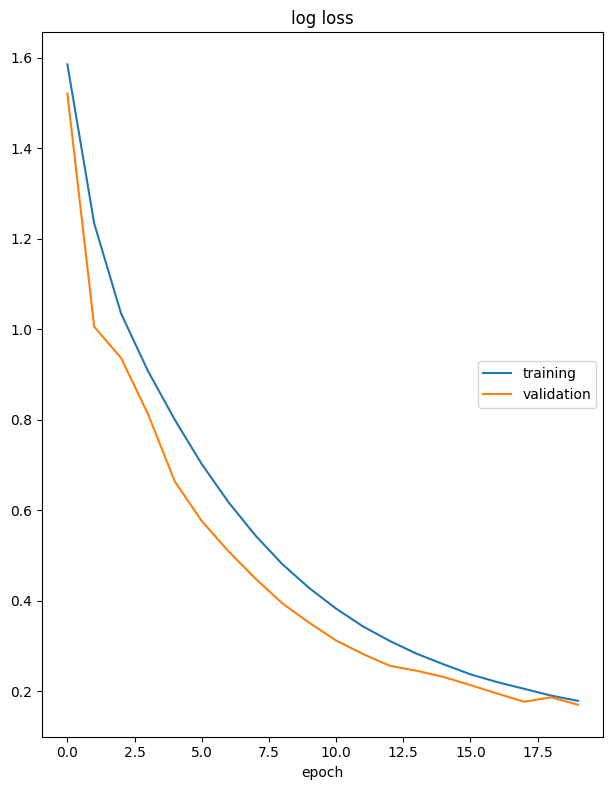

100%|██████████| 20/20 [03:10<00:00,  9.51s/it]

log loss
	training         	 (min:    0.178, max:    1.586, cur:    0.178)
	validation       	 (min:    0.170, max:    1.521, cur:    0.170)


In [207]:
from tqdm import tqdm

liveloss = PlotLosses()
for i in tqdm(range(nepochs)):
    train_loss = train(unet, optimiser, mseloss, train_loader)
    valid_loss = valid(unet, mseloss, val_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

In [209]:
model_save_name = 'unet_seis_class_lr_5e-4_wd_5e-4_ep_20_clw.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = f"/content/drive/MyDrive/models/{model_save_name}" # use this to store in your Google Drive storage
# path = f'./{model_save_name}'                               # use this to store locally (it will be erased once the colab session is over)
torch.save(unet.state_dict(), path)

In [270]:
# get the test dataset and labels
test_dataset = SeismicSliceDataset(seismic_path='data/test_once/test1_seismic.npy', labels_path='data/test_once/test1_labels.npy')
test_loader   = DataLoader(test_dataset,   batch_size=batch_size, shuffle=False)

In [271]:
def evaluate(model, data_loader, device):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)              # (B,1,H,W)
            y = y.to(device)              # (B,1,H,W) or (B,H,W)

            if y.ndim == 4:               # (B,1,H,W) → (B,H,W)
                y = y.squeeze(1)

            logits = model(X)             # (B,K,H,W)

            all_logits.append(logits.cpu())
            all_labels.append(y.cpu())

    all_logits = torch.cat(all_logits, dim=0)   # (N,K,H,W)
    all_labels = torch.cat(all_labels, dim=0)   # (N,H,W)

    return all_logits, all_labels

In [272]:
# make a prediction
logits, y_true = evaluate(unet, test_loader, device)

y_pred = torch.argmax(logits, dim=1)   # (N,H,W)
y_pred.shape, y_true.shape

(torch.Size([200, 701, 255]), torch.Size([200, 701, 255]))

In [273]:
y_pred[0].shape, y_true[0].shape

(torch.Size([701, 255]), torch.Size([701, 255]))

Text(0.5, 1.0, 'Facies Interpretation')

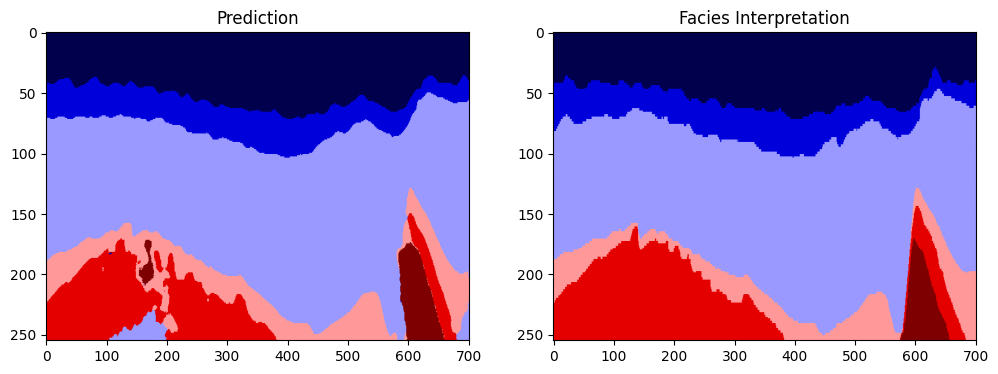

In [284]:
# plot the pred and real side by side
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(y_pred[180].permute(1, 0), cmap='seismic', aspect='auto')
ax1.set_title('Prediction')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y_true[180].permute(1, 0), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

In [285]:
import numpy as np
import torch

def segmentation_metrics_from_logits(
    logits: torch.Tensor,
    y_true: torch.Tensor,
    n_classes: int,
    ignore_index: int | None = None
):
    """
    Compute segmentation metrics (Pixel Acc, Mean Acc, IoU, FWIoU)
    from model logits and integer ground-truth labels.

    Parameters
    ----------
    logits : torch.Tensor
        Shape (N, C, H, W) - raw model outputs (logits)
    y_true : torch.Tensor
        Shape (N, H, W) or (N, 1, H, W) - integer class labels
    n_classes : int
        Number of classes C
    ignore_index : int or None
        Label value to ignore in metrics (e.g. 255). If None, no ignore.

    Returns
    -------
    scores : dict
        Same keys as the repo's runningScore.get_scores()
    cls_iou : dict
        class_id -> IoU
    """

    # --- shape fix for labels ---
    if y_true.ndim == 4:  # (N,1,H,W) -> (N,H,W)
        y_true = y_true.squeeze(1)

    # --- convert logits -> predicted labels ---
    y_pred = torch.argmax(logits, dim=1)  # (N,H,W)

    # --- move to numpy ---
    lt = y_true.detach().cpu().numpy().astype(np.int64)
    lp = y_pred.detach().cpu().numpy().astype(np.int64)

    # --- helper: fast confusion matrix for one image ---
    def fast_hist(label_true, label_pred, n_class):
        if ignore_index is not None:
            mask = (label_true != ignore_index) & (label_true >= 0) & (label_true < n_class)
        else:
            mask = (label_true >= 0) & (label_true < n_class)

        hist = np.bincount(
            n_class * label_true[mask] + label_pred[mask],
            minlength=n_class**2
        ).reshape(n_class, n_class)

        return hist

    # --- accumulate confusion matrix over all images ---
    hist = np.zeros((n_classes, n_classes), dtype=np.float64)
    for t, p in zip(lt, lp):
        hist += fast_hist(t.flatten(), p.flatten(), n_classes)

    # --- metrics (same as runningScore) ---
    acc = np.diag(hist).sum() / (hist.sum() + 1e-12)

    acc_cls = np.diag(hist) / (hist.sum(axis=1) + 1e-12)
    mean_acc_cls = np.nanmean(acc_cls)

    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-12)
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / (hist.sum() + 1e-12)
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()

    cls_iu = dict(zip(range(n_classes), iu))

    scores = {
        "Pixel Acc: ": float(acc),
        "Class Accuracy: ": acc_cls,              # numpy array length C
        "Mean Class Acc: ": float(mean_acc_cls),
        "Freq Weighted IoU: ": float(fwavacc),
        "Mean IoU: ": float(mean_iu),
        "confusion_matrix": hist
    }

    return scores, cls_iu


In [286]:
scores, cls_iou = segmentation_metrics_from_logits(
    logits=logits,
    y_true=y_true,
    n_classes=6,
    ignore_index=None  # set None if you don't have ignore pixels
)

# display the scores and cls_iou neatly like a table

print(f"Pixel Acc: {scores["Pixel Acc: "]}")
print("Class Acc: ")
for i in range(scores["Class Accuracy: "].shape[0]):
    print(f"Class {i} Acc: {scores["Class Accuracy: "][i]}")
print(f"Mean Class Acc: {scores["Mean Class Acc: "]}")
print(f"Freq Weighted IoU: {scores["Freq Weighted IoU: "]}")
print(f"Mean IoU: {scores["Mean IoU: "]}")
print("Per-class IoU:")
for k, v in cls_iou.items():
    print(f"Class {k} IoU: {v}")

Pixel Acc: 0.8596668904366311
Class Acc: 
Class 0 Acc: 0.9814720326272659
Class 1 Acc: 0.9091988171519864
Class 2 Acc: 0.971451640634766
Class 3 Acc: 0.8993967252868832
Class 4 Acc: 0.420452584746276
Class 5 Acc: 0.5130827844114747
Mean Class Acc: 0.7825090974764422
Freq Weighted IoU: 0.7549490782676697
Mean IoU: 0.6487292383816943
Per-class IoU:
Class 0 IoU: 0.8893446902870427
Class 1 IoU: 0.8011622945486278
Class 2 IoU: 0.8583638546232335
Class 3 IoU: 0.5952457098948067
Class 4 IoU: 0.4149559508482263
Class 5 IoU: 0.33330293008822826


In [287]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names=None, normalize=False):
    """
    cm : ndarray (C,C)
    normalize : if True, normalize rows (GT-wise)
    """

    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="viridis")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))

    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_yticklabels(class_names)

    # write values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, txt, ha="center", va="center",
                    color="white" if val > cm.max()/2 else "black")

    plt.tight_layout()
    plt.show()


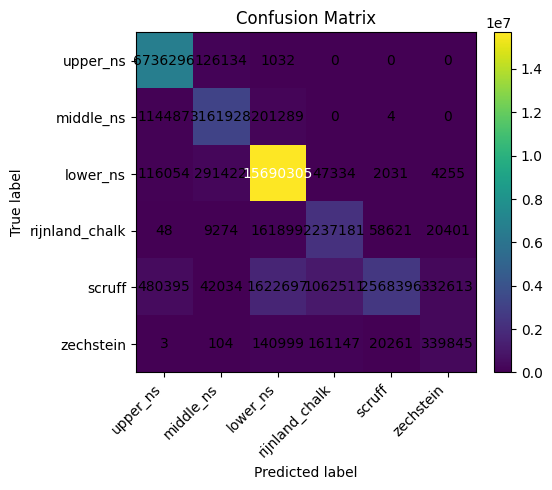

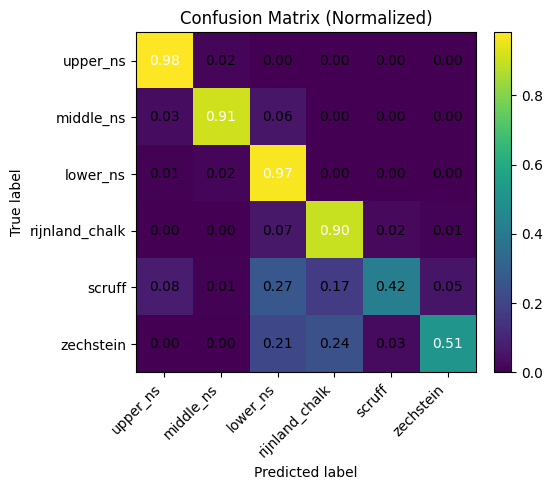

In [288]:
class_names = ['upper_ns', 'middle_ns', 'lower_ns',
                   'rijnland_chalk', 'scruff', 'zechstein']

cm = scores["confusion_matrix"]
plot_confusion_matrix(cm, class_names=class_names, normalize=False)
plot_confusion_matrix(cm, class_names=class_names, normalize=True)

In [289]:
test_dataset_2 = SeismicSliceDataset(seismic_path='data/test_once/test2_seismic.npy', labels_path='data/test_once/test2_labels.npy')
test_loader_2   = DataLoader(test_dataset_2,   batch_size=batch_size, shuffle=False)

In [290]:
# make a prediction
logits_2, y_true_2 = evaluate(unet, test_loader_2, device)

y_pred_2 = torch.argmax(logits_2, dim=1)   # (N,H,W)
y_pred_2.shape, y_true_2.shape

(torch.Size([601, 200, 255]), torch.Size([601, 200, 255]))

Text(0.5, 1.0, 'Facies Interpretation')

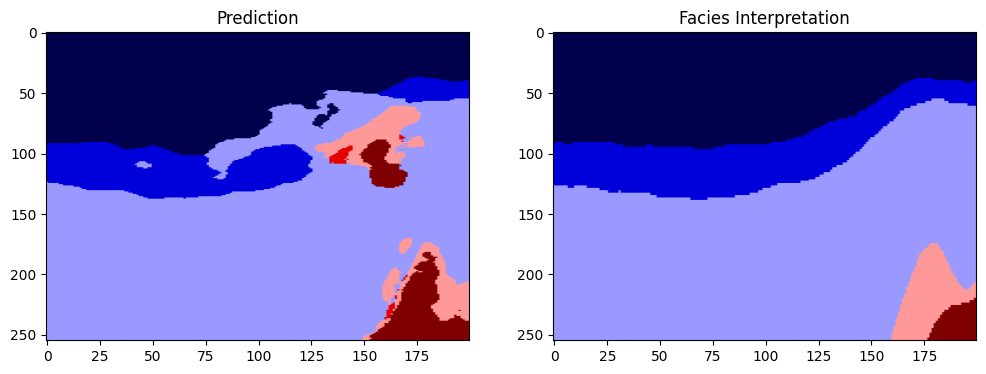

In [303]:
# plot the pred and real side by side
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(y_pred_2[500].permute(1, 0), cmap='seismic', aspect='auto')
ax1.set_title('Prediction')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y_true_2[500].permute(1, 0), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

In [304]:
scores, cls_iou = segmentation_metrics_from_logits(
    logits=logits_2,
    y_true=y_true_2,
    n_classes=6,
    ignore_index=None  # set None if you don't have ignore pixels
)

# display the scores and cls_iou neatly like a table

print(f"Pixel Acc: {scores["Pixel Acc: "]}")
print("Class Acc: ")
for i in range(scores["Class Accuracy: "].shape[0]):
    print(f"Class {i} Acc: {scores["Class Accuracy: "][i]}")
print(f"Mean Class Acc: {scores["Mean Class Acc: "]}")
print(f"Freq Weighted IoU: {scores["Freq Weighted IoU: "]}")
print(f"Mean IoU: {scores["Mean IoU: "]}")
print("Per-class IoU:")
for k, v in cls_iou.items():
    print(f"Class {k} IoU: {v}")

Pixel Acc: 0.9019536393592379
Class Acc: 
Class 0 Acc: 0.9531169737742822
Class 1 Acc: 0.7720993144791557
Class 2 Acc: 0.9621321273721927
Class 3 Acc: 0.6254930044981352
Class 4 Acc: 0.2597434960295046
Class 5 Acc: 0.36139111273450175
Mean Class Acc: 0.6556626714812953
Freq Weighted IoU: 0.8426640083358151
Mean IoU: 0.5577864347242216
Per-class IoU:
Class 0 IoU: 0.9348399119361517
Class 1 IoU: 0.7122520344731279
Class 2 IoU: 0.9019912842047694
Class 3 IoU: 0.4358666021317468
Class 4 IoU: 0.14947597366125312
Class 5 IoU: 0.21229280193828062


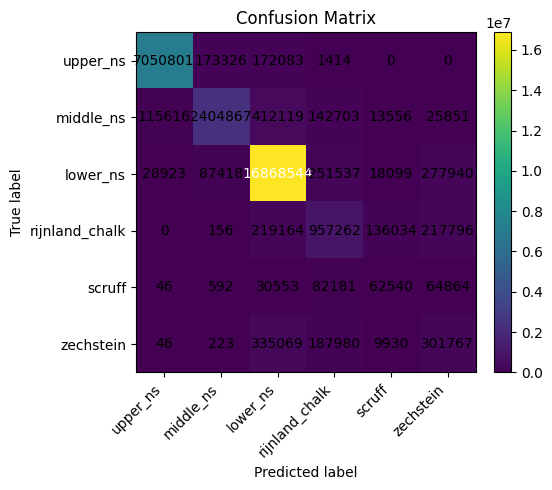

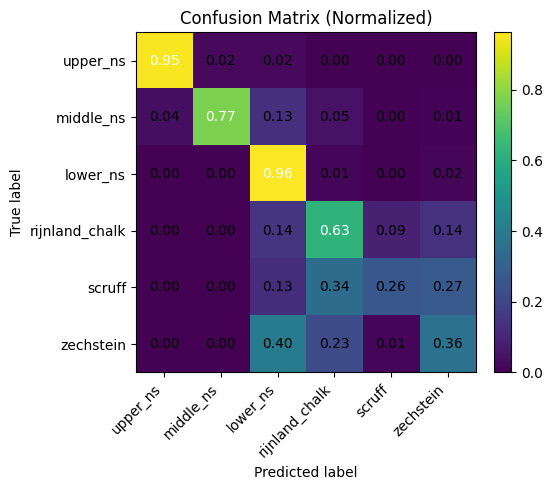

In [306]:
cm = scores["confusion_matrix"]
plot_confusion_matrix(cm, class_names=class_names, normalize=False)
plot_confusion_matrix(cm, class_names=class_names, normalize=True)